# Multi-Fidelity Kolmogorov-Arnold Networks (MFKANs) in Neuromancer

This tutorial demonstrates the use of Multi-Fidelity Kolmogorov-Arnold Networks (MFKANs) for learning functions from both high and low-fidelity data sources. MFKANs enable efficient training with limited expensive high-fidelity data by leveraging correlations with more abundant low-fidelity data.

This example is divided into three parts. First, we train a KAN with only low-fidelity data. We then proceed with training a KAN with only high-fidelity data. Finally, we demonstrate how to use an MFKAN to leverage both high-fidelity and low-fidelity data, yielding results that are more accurate.


### Kolmogorov-Arnold Networks (KANs)
KANs are neural networks inspired by the Kolmogorov-Arnold theorem, providing an alternative to traditional multilayer perceptrons (MLPs). KANs approximate multivariate functions by decomposing them into sums of nested univariate functions. Specifically, a KAN approximates a function $f(x)$ as:

$$
f(x) \approx \sum_{i_{nl-1}=1}^{m_{nl-1}} \phi_{nl-1, i_{nl-1}} \left( \cdots \sum_{i_1=1}^{m_1} \phi_{1, i_2, i_1} \left( \sum_{i_0=1}^{m_0} \phi_{0, i_1, i_0}(x_{i_0}) \right) \cdots \right)
$$

where $\phi_{j, i, k}$ are trainable, univariate activation functions represented by splines. This structure enables KANs to locally adjust function behavior with flexible resolution, making them effective for tasks with noisy data or where high interpretability is needed.

### Multi-Fidelity KANs (MFKANs)
MFKANs extend KANs to efficiently learn from multiple data fidelities through a composite architecture consisting of three main components:

1. **Low-fidelity KAN** ($\mathcal{K}_L$): Standard KAN block, with polynomial degree $k>1$. Learns the low-fidelity data behavior.
2. **Linear KAN** ($\mathcal{K}_l$): A linear KAN block (polynomial degree $k=1$) and two grid points. Captures linear correlations between fidelities.
3. **Nonlinear KAN** ($\mathcal{K}_{nl}$): Standard KAN block, with polynomial degree $k>1$, but that also takes the outputs of the low-fidelity KAN as input. Models nonlinear corrections.

The multi-fidelity prediction $\mathcal{K}_M$ is given by a convex combination:

$$
\mathcal{K}_M(x) = \alpha \mathcal{K}_{nl}(x) + (1-\alpha)\mathcal{K}_l(x)
$$

where $\alpha$ is a trainable parameter, and $\mathcal{K}_{nl}, \mathcal{K}_l$ take as additional input the predictions of the low-fidelity KAN $\mathcal{K}_L$. This structure allows MFKANs to:
- Leverage abundant low-fidelity data for basic feature learning
- Use limited high-fidelity data efficiently by separating linear and nonlinear correlations
- Maintain accuracy even with sparse high-fidelity sampling

<img src="../figs/mfkan_diagram.png" alt="MFKAN Architecture" width="50%"/>

### Key Applications
MFKANs are particularly useful for:
- Function fitting with multiple simulation fidelities
- Multi-resolution data fusion
- Efficient surrogate modeling for expensive computations

### References

[1] [Liu, Ziming, et al. (2024). KAN: Kolmogorov-Arnold Networks.](https://arxiv.org/abs/2404.19756)

[2] https://github.com/Blealtan/efficient-kan

[3] [Howard, Amanda A., et al. (2024) Multifidelity Kolmogorov-Arnold networks.](https://arxiv.org/abs/2410.14764)


### Install Neuromancer
(Note: You can skip this step if running locally.)
(Note 2: Colab might ask you to restart your session after installing Neuromancer. Simply restart it when prompted.)

In [ ]:
import os

# Check if the neuromancer directory already exists
if not os.path.isdir('neuromancer'):
    # Clone the specific branch of the repository
    !git clone --branch feature/mfkans https://github.com/pnnl/neuromancer.git

# Navigate to the repository directory
%cd neuromancer

# Install the repository with the required extras
!pip install -e .[docs,tests,examples]


### Import dependencies

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from neuromancer.dataset import DictDataset
from neuromancer.modules import blocks
from neuromancer.system import Node, System
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.loggers import LossLogger

# filter some user warnings from torch broadcast
import warnings
warnings.filterwarnings("ignore")


### Configure device and RNG seed

In [2]:
# Set default dtype to float32
torch.set_default_dtype(torch.float)
#PyTorch random number generator
torch.manual_seed(1234)
# Random number generators in other libraries
np.random.seed(1234)
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Generate and visualize data

We will use the following jump function with a linear correlation. In this example we have sparse, high-fidelity data, which is not sufficient to capture the jump. 
$$
    y_L(x) = \begin{cases} 
      0.1\left[0.5(6x-2)^2 \sin(12x-4) + 10(x-0.5)-5\right] & x \leq 0.5 \\
      0.1\left[0.5(6x-2)^2 \sin(12x-4) + 10(x-0.5)-2\right] & x > 0.5  
   \end{cases}
$$

$$
y_H(x) = 2y_L(x) -2x + 2
$$

for $ x \in [0, 1].$ We take $ N_{L}= 51 $ low-fidelity data points evenly distributed in $[0,1]$ and $ N_{H} = 5 $ high-fidelity data points evenly spaced in $[0.1, 0.93]$. 

We also generate $N_\text{full} = 200$ data points to test low, high and multi-fidelity models.


In [3]:
# Define the low-fidelity and high-fidelity functions
def yL(x):
    y = torch.where(x < 0.5,
                    0.5*(6*x-2)**2 * torch.sin(12*x-4) + 10*(x-0.5)-5,
                    3 + 0.5*(6*x-2)**2 * torch.sin(12*x-4) + 10*(x-0.5)-5)
    return y / 10

def yH(x):
    return 2*(yL(x)) - 2*x + 2


# Generate three datasets: low-fidelity 
x_data_L = torch.linspace(0, 1, 51).reshape(-1, 1)
y_data_L = yL(x_data_L)

x_data_H = torch.linspace(.1, .93, 5).reshape(-1, 1)
y_data_H = yH(x_data_H)

x_data_full = torch.linspace(0, 1, 200).reshape(-1, 1)
y_data_full = yH(x_data_full)


A visualization of the data is shown below. 

The circular markers denote the sampled high-fidelity (green) and low-fidelity points, and the solid lines denote the exact functions defined above.

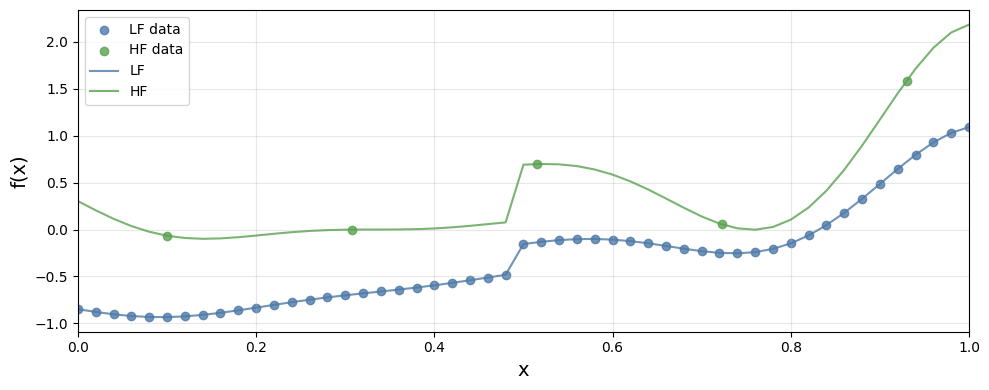

In [20]:
# Visualize the data
plt.figure(figsize=(10, 4))

# Plot data points
plt.scatter(x_data_L.numpy(), y_data_L.numpy(), c="#4e79a7", label='LF data', alpha=0.8)
plt.scatter(x_data_H.numpy(), y_data_H.numpy(), c="#59a14f", label='HF data', alpha=0.8)

# Plot continuous functions
plt.plot(x_data_L.numpy(), yL(x_data_L).numpy(), "#4e79a7", label='LF', alpha=0.8)
plt.plot(x_data_L.numpy(), yH(x_data_L).numpy(), "#59a14f", label='HF', alpha=0.8)

# Customize plot
plt.xlim(0, 1)
plt.xlabel('x', fontsize=14)
plt.ylabel('f(x)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [4]:
# We will leverage Neuromancer's DictDataset to wrap the different datasets, giving them names
train_data_L   = DictDataset({'x': x_data_L.to(device), 'y': y_data_L.to(device)}, name='train_L')
train_data_H   = DictDataset({'x': x_data_H.to(device), 'y': y_data_H.to(device)}, name='train_H')
data_full      = DictDataset({'x': x_data_full.to(device), 'y': y_data_full.to(device)}, name='data_full')

# Here we leverage Torch's DataLoader class, that can use Neuromancer's DictDataset directly
batch_size_L    = train_data_L.datadict['x'].shape[0]
batch_size_H    = train_data_H.datadict['x'].shape[0]
batch_size_full = data_full.datadict['x'].shape[0]

train_loader_L = torch.utils.data.DataLoader(train_data_L, batch_size=batch_size_L,
                                              collate_fn=train_data_L.collate_fn,
                                              shuffle=False)

train_loader_H = torch.utils.data.DataLoader(train_data_H, batch_size=batch_size_H,
                                              collate_fn=train_data_H.collate_fn,
                                              shuffle=False)


data_loader_full = torch.utils.data.DataLoader(data_full, batch_size=batch_size_full,
                                              collate_fn=data_full.collate_fn,
                                              shuffle=False)


### Part 1: Create a single-fidelity KAN and train on low-fidelity data

We begin by creating the low-fidelity KAN block, which will learn from the low-fidelity data. The `KANBlock` in Neuromancer provides a flexible implementation of Kolmogorov-Arnold Networks.

- **`insize`**: *(int)* – Dimensionality of the input space. Set to 1 for our univariate function.

- **`outsize`**: *(int)* – Dimensionality of the output space. Set to 1 as we're predicting a scalar value.

- **`hsizes`**: *(list[int])* – Architecture of hidden layers. Here we use a single hidden layer with 5 nodes.

- **`grid_sizes`**: *(list[int])* – Number of grid points for B-spline evaluation. Controls the resolution of our function approximation.

- **`spline_order`**: *(int)* – Order of B-spline basis functions.

- **`base_activation`**: *(callable)* – Base activation function.

The low-fidelity KAN is wrapped in a Neuromancer `Node`. This node maps input 'x' to predicted output 'y_hat'.


In [5]:
# Define the low-fidelity KAN model
kan_L = blocks.KANBlock(
    insize=1,                          # Input size
    outsize=1,                         # Output size
    hsizes=[5],                        # KAN shape is [insize, hsizes, outsize]
    grid_sizes=[5],                    # Grid size. Note: Neuromancer currently only support single-grid
    spline_order=3,                    # 3rd order splines
    base_activation=torch.nn.Sigmoid,  # Nonlinear base activation function
).to(device)


# Symbolic wrapper of the LF KAN
kan_wrapper_L = Node(kan_L, ['x'], ['y_hat'], name='wrapper_L')


#### Define symbolic variables and losses for low-fidelity model

In the next cell, we construct a loss function for the low-fidelity model. The goal is to minimize the error between the predicted values, $\hat{f}(x) = $ `y_hat`, and the true target values, $f(x) = $ `y`, across the dataset.

**Symbolic Variables:**

- `x`: Input variables, where $x \in [0, 1]$.
- `y`: True target values from the function $f(x)$.
- `y_hat`: Predicted values produced by KAN model, $\hat{y}$.


**Data Loss for KAN:**

The data loss for the low-fidelity KAN, denoted as `loss_data_L`, is the mean squared error between the KAN predictions, `y_hat`, and the true target values, `y`:

$$
\ell_{\text{L}} = \text{scaling} \cdot \frac{1}{N_{\text{L}}} \sum_{i=1}^{N_{\text{L}}} \left( y_i - \hat{y}_i \right)^2
$$

where $N_{\text{L}}$ denotes the number of points in the low-fidelity dataset. This loss term guides the KAN model to learn the target function.

**Loss Function:**

The loss function is then constructed using Neuromancer's `PenaltyLoss`:

- **`loss_L`**: Defined for the KAN model, using `loss_data_L`.

In this case, we have left the problem unconstrainted. However, constraints can be added via the `constraints` argument.

In [6]:
# Define symbolic variables for low-fidelity model
x_L = variable('x')
y_L = variable('y')
y_hat_L = variable('y_hat')

# Define losses
loss_data_L = (y_L == y_hat_L)^2
loss_data_L.name = "ref_loss_L"

# Create loss function
loss_L = PenaltyLoss(objectives=[loss_data_L], constraints=[])



#### Construct Neuromancer `Problem` object and train low-fidelity model

Here we train a single-fidelity KAN with low-fidelity data.

In [7]:
# Construct the optimization problem
problem_L = Problem(nodes=[kan_wrapper_L], loss=loss_L, grad_inference=True)

# Create trainer for LF model
init_lr =0.005
epoch_verbose_L = 1000
num_epochs_L=10000
logger_L = LossLogger(args=None, savedir='test_L', verbosity=epoch_verbose_L, stdout=['train_L_loss'])


trainer_L = Trainer(
    problem_L.to(device),
    train_data=train_loader_L,
    dev_data=train_loader_L,
    optimizer= torch.optim.Adam(problem_L.parameters(), lr=init_lr),
    epoch_verbose=epoch_verbose_L,
    logger=logger_L,
    epochs=num_epochs_L,
    train_metric='train_L_loss',
    eval_metric='train_L_loss',
    dev_metric='train_L_loss',
    warmup=num_epochs_L,
    device=device
)


# Train LF model
best_model_L = trainer_L.train()
problem_L.load_state_dict(best_model_L)
trained_model_L = problem_L.nodes[0]


Number of parameters: 100
epoch: 0	train_L_loss: 0.28872	eltime:  0.03216
epoch: 1000	train_L_loss: 0.00097	eltime:  1.33816
epoch: 2000	train_L_loss: 0.00070	eltime:  2.64144
epoch: 3000	train_L_loss: 0.00060	eltime:  3.92178
epoch: 4000	train_L_loss: 0.00054	eltime:  5.23791
epoch: 5000	train_L_loss: 0.00042	eltime:  6.52041
epoch: 6000	train_L_loss: 0.00033	eltime:  7.82992
epoch: 7000	train_L_loss: 0.00013	eltime:  9.15595
epoch: 8000	train_L_loss: 0.00003	eltime:  10.45523
epoch: 9000	train_L_loss: 0.00000	eltime:  11.71683


### Part 2: Create a single-fidelity KAN and train on high-fidelity data

Next, we construct a loss function for the high-fidelity model. 

The idea is the same as before: we will minimize the error between the predicted values, $\hat{f}(x) = $ `y_hat`, and the true target values, $f(x) = $ `y`, across the high-fidelity dataset.


In [8]:
# Define the high-fidelity KAN model
kan_H = blocks.KANBlock(
    insize=1,                          # Input size
    outsize=1,                         # Output size
    hsizes=[5],                        # KAN shape is [insize, hsizes, outsize]
    grid_sizes=[5],                    # Grid size. Note: Neuromancer currently only support single-grid
    spline_order=3,                    # 3rd order splines
    base_activation=torch.nn.Sigmoid,  # Nonlinear base activation function
).to(device)

# Symbolic wrapper of the HF KAN
kan_wrapper_H = Node(kan_H, ['x'], ['y_hat'], name='wrapper_H')


#### Define symbolic variables and losses for high-fidelity KAN

The data loss for the high-fidelity KAN, denoted as `loss_data_H`, is the mean squared error between the KAN predictions, `y_hat`, and the true target values, `y`:

$$
\ell_{\text{H}} = \text{scaling} \cdot \frac{1}{N_{\text{H}}} \sum_{i=1}^{N_{\text{H}}} \left( y_i - \hat{y}_i \right)^2
$$

where $N_{\text{H}}$ denotes the number of points in the high-fidelity dataset. Similarly to the low-fidelity case, we construct the loss function using Neuromancer's `PenaltyLoss`.

In [9]:
# Define symbolic variables for HF model
x_H = variable('x')
y_H = variable('y')
y_hat_H = variable('y_hat')

# Define losses
loss_data_H = (y_H == y_hat_H)^2
loss_data_H.name = "ref_loss_H"

# Create loss function
loss_H = PenaltyLoss(objectives=[loss_data_H], constraints=[])



#### Construct Neuromancer `Problem` object and train high-fidelity model

Here we train a KAN with the high-fidelity data alone.

In [10]:
# Construct the high-fidelity optimization problem
problem_H = Problem(nodes=[kan_wrapper_H], loss=loss_H, grad_inference=True)

# Create trainer for high-fidelity model
init_lr =0.005
epoch_verbose_H = 1000
num_epochs_H=10000
logger_H = LossLogger(args=None, savedir='test_HF', verbosity=epoch_verbose_H, stdout=['train_H_loss'])

trainer_H = Trainer(
    problem_H.to(device),
    train_data=train_loader_H,
    dev_data=train_loader_H,
    optimizer= torch.optim.Adam(problem_H.parameters(), lr=init_lr),
    epoch_verbose=epoch_verbose_H,
    logger=logger_H,
    epochs=num_epochs_H,
    train_metric='train_H_loss',
    eval_metric='train_H_loss',
    dev_metric='train_H_loss',
    warmup=num_epochs_H,
    device=device
)

# Train HF model
best_model_H = trainer_H.train()
problem_H.load_state_dict(best_model_H)
trained_model_H = problem_H.nodes[0]



Number of parameters: 100
epoch: 0	train_H_loss: 0.62511	eltime:  0.00242
epoch: 1000	train_H_loss: 0.00000	eltime:  1.00987
epoch: 2000	train_H_loss: 0.00000	eltime:  1.98075
epoch: 3000	train_H_loss: 0.00000	eltime:  2.96927
epoch: 4000	train_H_loss: 0.00000	eltime:  3.93970
epoch: 5000	train_H_loss: 0.00000	eltime:  4.90751
epoch: 6000	train_H_loss: 0.00000	eltime:  5.88304
epoch: 7000	train_H_loss: 0.00000	eltime:  6.87024
epoch: 8000	train_H_loss: 0.00000	eltime:  7.88022
epoch: 9000	train_H_loss: 0.00000	eltime:  8.85284


### Part 3: Create a multi-fidelity KAN and train

The `MultiFidelityKAN` block in Neuromancer enables learning from both low and high-fidelity data sources. The architecture **uses a pre-trained, low-fidelity model, along with high-fidelity data to capture correlations between fidelities**.


- **`sfkan`**: *(KANBlock)* – Pre-trained low-fidelity KAN model that provides base predictions.

- **`insize=1`**: *(int)* – Dimensionality of the input space. Set to 1 for our univariate function.

- **`outsize=1`**: *(int)* – Dimensionality of the output space. Set to 1 as we're predicting a scalar value.

- **`hsizes=[5]`**: *(list[int])* – Architecture of nonlinear KAN's hidden layers. The linear KAN is automatically configured as [insize, outsize].

- **`grid_sizes=[4]`**: *(list[int])* – Number of grid points for B-spline evaluation in the nonlinear KAN.

- **`spline_order=2`**: *(int)* – Order of B-spline basis functions.

- **`alpha_init=0.1`**: *(float)* – Initial value for the learnable weight $\alpha$ that controls the convex combination of linear and nonlinear networks.

- **`base_activation`**: *(callable)* – Base activation function.

The multi-fidelity KAN is wrapped in a Neuromancer `Node`. This node maps input 'x' to the high-fidelity prediction 'y_hat'.


In [11]:
# Define the multi-fidelity KAN model

# Here we use Neuromancer's MultiFidelityKAN block. The syntax is very similar to KANBlock!
kan_M = blocks.MultiFidelityKAN(
    sfkan=kan_L,                        # A trained, low-fidelity model
    insize=1,                           # Input size
    outsize=1,                          # Output size
    hsizes=[5],                         # Nonlinear KAN shape: [insize, hsizes, outsize]. Shape of linear KAN is always [insize, outsize].
    grid_sizes=[4],                     # Grid size. Note: Neuromancer currently only support single-grid
    spline_order=2,                     # 2nd order splines
    alpha_init=0.1,                     # Initial value of learnable weight alpha, used in the convex combination of linear and nonlinear nets.
    base_activation=torch.nn.Sigmoid,   # Nonlinear base activation function
).to(device)

# Symbolic wrapper of the MF KAN
kan_wrapper_M = Node(kan_M, ['x'], ['y_hat'], name='kan_wrapper_M')



#### Define symbolic variables and losses for multi-fidelity KAN

The complete multi-fidelity KAN loss function consists of three components:

1. **Data Loss** - Mean squared error between the MFKAN predictions, `y_hat`, and the true target values, `y` on the high-fidelity data:
$$
\ell_{\text{data}} = \frac{1}{N_{\text{H}}} \sum_{i=1}^{N_{\text{H}}} \left( y_i - \hat{y}_i \right)^2
$$

2. **Alpha Loss** - Penalizes the magnitude of $\alpha$ to maximize linear correlations:
$$
\ell_{\text{alpha}} = \alpha^n
$$

3. **Regularization Loss** - Prevents overfitting by penalizing B-spline coefficients on each layer $L$ of each KAN:
$$
\ell_{\text{reg}} = w \sum_{l=0}^{L-1} \|\Phi_{nl}\|
$$   
$$
\|\Phi_{nl}\| = \frac{1}{n_{\text{in}}n_{\text{out}}} \sum_{i=1}^{n_{\text{in}}} \sum_{j=1}^{n_{\text{out}}} |\phi_{i,j}^{nl}|^2
$$

The complete loss function combines these terms:
$$
\ell_{\text{total}} = \ell_{\text{data}} + \ell_{\text{alpha}} + \ell_{\text{reg}}
$$

***Note: In Neuromancer, the alpha and regularization losses are automatically handled internally, so that the user only need to set up the data loss!***


Finally, create a `PenaltyLoss` and use the `loss_data_MF` as our objective function. 

In [12]:
# Define symbolic variables for MF model
x_M = variable('x')
y_M = variable('y')
y_hat_M = variable('y_hat')

# Define losses
loss_data_M = (y_M == y_hat_M)^2
loss_data_M.name = "ref_loss_M"

# Create loss function
loss_M = PenaltyLoss(objectives=[loss_data_M], constraints=[])


#### Construct Neuromancer `Problem` object and train multi-fidelity model

In this section, we create and train the complete Multi-Fidelity KAN (MFKAN) architecture. We achieve multi-fidelity learning by using the low-fidelity, pre-trained model obtained in Part 1 with high-fidelity data.


In [13]:
# Construct the MF optimization problem
problem_M = Problem(nodes=[kan_wrapper_M], loss=loss_M, grad_inference=True)

# Create trainer for MF model
num_epochs_M = 20000
epoch_verbose_M = 2000
logger_M = LossLogger(args=None, savedir='test_H', verbosity=epoch_verbose_M, stdout=['train_H_loss'])


trainer_M = Trainer(
    problem_M.to(device),
    train_data=train_loader_H,
    dev_data=train_loader_H,
    optimizer=torch.optim.Adam(problem_M.parameters(), lr=init_lr),
    epoch_verbose=epoch_verbose_M,
    logger=logger_M,
    epochs=num_epochs_M,
    train_metric='train_H_loss',
    eval_metric='train_H_loss',
    dev_metric='train_H_loss',
    warmup=num_epochs_M,
    multi_fidelity=True,
    device=device
)

# Train MF model
best_model_M = trainer_M.train()
problem_M.load_state_dict(best_model_M)
trained_model_M = problem_M.nodes[0]


Number of parameters: 131
epoch: 0	train_H_loss: 0.50882	eltime:  0.00930
epoch: 2000	train_H_loss: 0.01870	eltime:  3.63984
epoch: 4000	train_H_loss: 0.00249	eltime:  7.14588
epoch: 6000	train_H_loss: 0.00095	eltime:  10.51406
epoch: 8000	train_H_loss: 0.00089	eltime:  13.85415
epoch: 10000	train_H_loss: 0.00056	eltime:  17.26906
epoch: 12000	train_H_loss: 0.00027	eltime:  20.61776
epoch: 14000	train_H_loss: 0.00035	eltime:  23.99374
epoch: 16000	train_H_loss: 0.00022	eltime:  27.38162
epoch: 18000	train_H_loss: 0.00024	eltime:  30.81050


#### Print $\alpha$ to verify

The value of $\alpha$, initially set as 0.1, changed during training. It should, however, remain small, as the model is penalized with $\alpha^4$ to force the method to learn the maximum linear correlation. We can verify the value of $\alpha$ by printing its value:

In [15]:
# Print value of final parameter alpha
for idx,alpha in enumerate(kan_M.alpha):
    print(f"alpha_{idx} = {alpha}")


alpha_0 = Parameter containing:
tensor(0.0167, requires_grad=True)


### Plot results

In this section, we compare the predictions of the three models. To recap, we have:

- A low-fidelity model $\mathcal{K}_L$, trained on abundant, shifted low-fidelity data, $x_L$
- A high-fidelity model $\mathcal{K}_H$, trained on sparse, high-fidelity data, $x_H$
- A multi-fidelity model, that is trained with high-fidelity data $x_H$ and predictions of the low-fidelity model on the high-fidelity data, i.e., $\mathcal{K}_L(x_H)$

Figures (a) and (b) show a comparison between low and high-fidelity data and the losses versus epochs, respectively.

Figure (c) shows the predictions of the low-fidelity model versus the low-fidelity data, demonstrating that the low-fidelity KAN was able to learn the function.

In Figure (d), we compare the high-fidelity and multi-fidelity model predictions. The red dotted line shows that even though the high-fidelity model was able to interpolate the sparse data (green dots), it severely missed the jump at $x = 0.5$. On the other hand, the multi-fidelity model was able to capture the jump and tracked the high-fidelity data with impressive accuracy. 

**Note: the multi-fidelity model only learned from the 5 high-fidelity points plus the predictions of the low-fidelity model on these high-fidelity points to achieve that level of accuracy!**

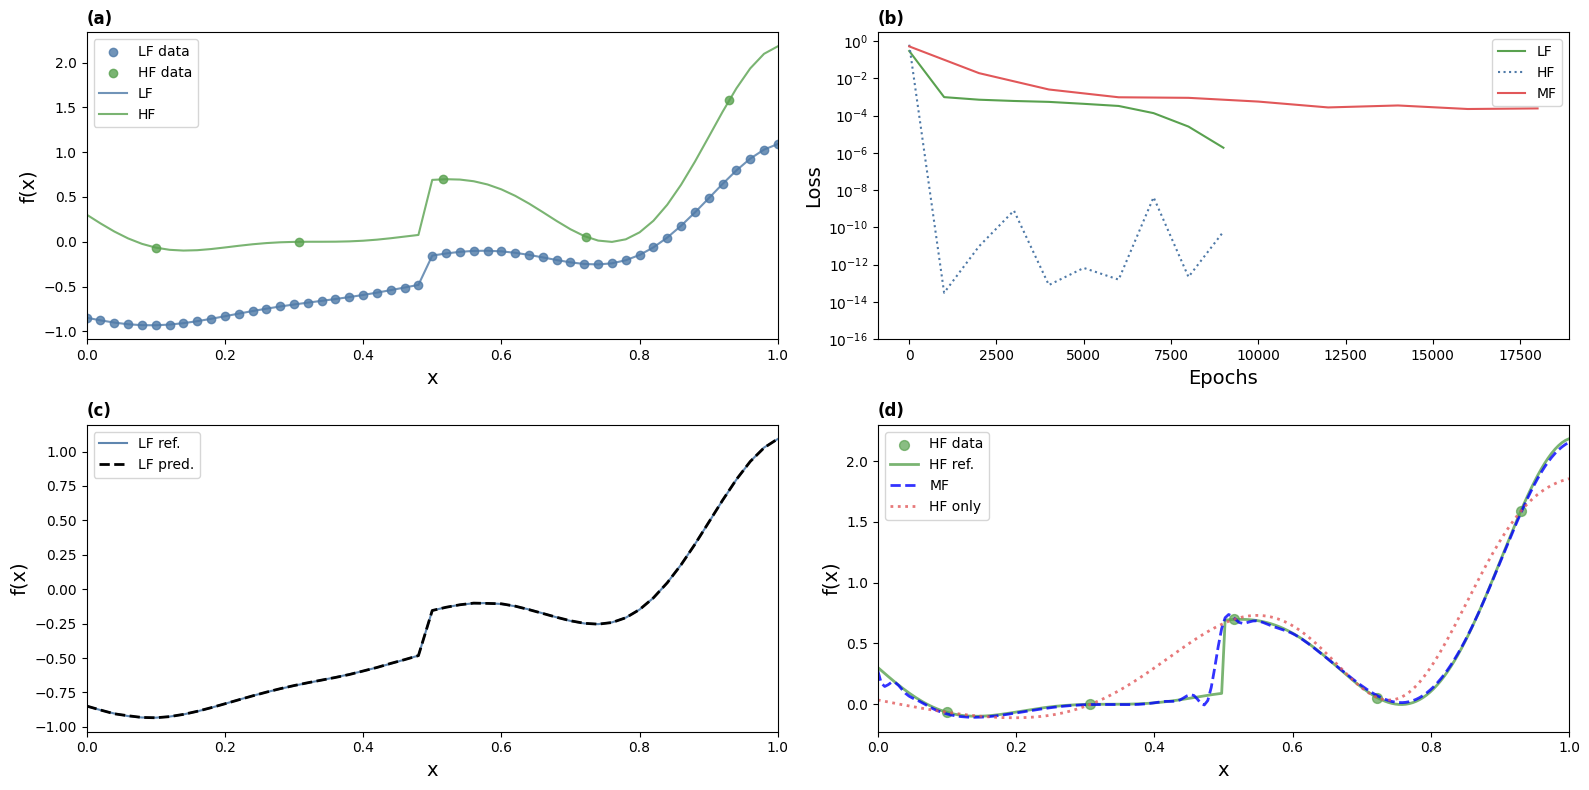

In [ ]:
# Make predictions
preds_H   = trained_model_H(data_full.datadict)['y_hat'].cpu().detach().numpy()      # high-fidelity predictions of full data
preds_L   = trained_model_L(train_data_L.datadict)['y_hat'].cpu().detach().numpy()  # low-fidelity predictions of low-fidelity data
preds_M   = trained_model_M(data_full.datadict)['y_hat'].cpu().detach().numpy()      # multi-fidelity predictions of full data

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 8), constrained_layout=True)

# Plot a): Sampled data and reference functions
axs[0, 0].scatter(x_data_L.numpy(), y_data_L.numpy(), c="#4e79a7", label='LF data', alpha=0.8)
axs[0, 0].scatter(x_data_H.numpy(), y_data_H.numpy(), c="#59a14f", label='HF data', alpha=0.8)
axs[0, 0].plot(x_data_L.numpy(), yL(x_data_L).numpy(), "#4e79a7", label='LF', alpha=0.8)
axs[0, 0].plot(x_data_L.numpy(), yH(x_data_L).numpy(), "#59a14f", label='HF', alpha=0.8)
axs[0, 0].set_xlim(0,1)
axs[0, 0].set_xlabel('x', fontsize=14)
axs[0, 0].set_ylabel('f(x)', fontsize=14)
axs[0, 0].legend(fontsize=10)
axs[0, 0].set_title('(a)', loc='left', fontweight='bold')

# Plot b): Evolution of losses vs epochs
losses_L = trainer_L.logger.get_losses()
losses_H = trainer_H.logger.get_losses()
losses_M = trainer_M.logger.get_losses()
epoch_losses_L = range(1, len(losses_L['train'])*epoch_verbose_L+1, epoch_verbose_L)
epoch_losses_H = range(1, len(losses_H['train'])*epoch_verbose_H+1, epoch_verbose_H)
epoch_losses_M = range(1, len(losses_M['train'])*epoch_verbose_M+1, epoch_verbose_M)

axs[0, 1].plot(epoch_losses_L,losses_L['train'], label='LF', color='#59a14f')
axs[0, 1].plot(epoch_losses_H,losses_H['train'], label='HF', linestyle='dotted', color='#4e79a7')
axs[0, 1].plot(epoch_losses_M,losses_M['train'], label='MF', color='#e15759') 
axs[0, 1].set_xlabel('Epochs', fontsize=14)
axs[0, 1].set_ylabel('Loss', fontsize=14)
axs[0, 1].set_yscale('log')
axs[0, 1].set_ylim(1e-16)
axs[0, 1].legend(fontsize=10)
axs[0, 1].set_title('(b)', loc='left', fontweight='bold')

# Plot c): LF predictions vs reference data
axs[1, 0].plot(x_data_L.numpy(), yL(x_data_L).numpy(), '#4e79a7', label='LF ref.', alpha=0.9)
axs[1, 0].plot(x_data_L.numpy(), preds_L, 'k--', label='LF pred.', linewidth=2)
axs[1, 0].set_xlim(0,1)
axs[1, 0].set_xlabel('x', fontsize=14)
axs[1, 0].set_ylabel('f(x)', fontsize=14)
axs[1, 0].legend(fontsize=10)
axs[1, 0].set_title('(c)', loc='left', fontweight='bold')

# Plot d): MF vs HF predictions and reference
axs[1,1].scatter(x_data_H.numpy(), y_data_H.numpy(), c="#59a14f", label='HF data', alpha=0.7, s=50)
axs[1,1].plot(x_data_full.numpy(), y_data_full.numpy(), '#59a14f', label='HF ref.', alpha=0.8, linewidth=2) # HF ref.
axs[1,1].plot(x_data_full.numpy(), preds_M, '--b', label='MF', alpha=0.8, linewidth=2) # Predictions of MF model on full data
axs[1,1].plot(x_data_full.numpy(), preds_H, '#e15759', linestyle='dotted', label='HF only', alpha=0.8, linewidth=2) # Predictions of HF model on full data
axs[1, 1].set_xlim(0,1)
axs[1, 1].set_xlabel('x', fontsize=14)
axs[1, 1].set_ylabel('f(x)', fontsize=14)
axs[1, 1].legend(fontsize=10)
axs[1, 1].set_title('(d)', loc='left', fontweight='bold')

plt.tight_layout()
plt.show()

# Optional: save your plot
# plt.savefig('MF_LF_Results_Inference_Neuromancer.png', dpi=300, bbox_inches='tight')

